In [34]:
%run Function_Master.ipynb
%run Parameterization.ipynb

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Coupled model parameterized to recreate Thamatrakoln results

In [ ]:
#Parameterization
alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3

Nn_0 = 1e20
Nr_0 = 1e20
Pu_0 = 1.5e14 * alpha 
Pi_0 = 1e5    * alpha 
Z_0  = 0.
Vi_0 = 1e8    * beta 
Ve_0 = 2.7e12 * beta

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = .85             # Maximum phytoplankton growth rate, Fig. 3 (a), irradience 300
γ_Z       = 0               # Growth rate / Assimilation frequency 
φ         = 3.5e-10 / beta  # Converted viral adsorption rate
g         = 0               # Maximum specific grazing rate

V_ind     = 4e5      #NT per individual virus, Table S1
S_ind     = 1.42e8   #NT per individual host, Table S1
ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair

λ_P       = 0   # Mortality & Respiration rate
λ_Z       = 0   # Linear mortality & respiration & egestion
λ_Z_hat   = 0   # Quadratic mortality & respiration & egestion
λ_E       = 0   # Mortality 
δ         = .45 # Host lysis rate


μ_V       = 3   # Max host NT recycling rate 
μ_V_prime = 1.6 # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0
μ_s       = 1
μ_P       = 0   # Remineralization fraction due to mortality
μ_delta   = 0   # Remineralization fraction due to lysis
μ_g       = 0   # Remineralization fraction due to sloppy-eating
μ_Z       = 0   # Remineralization fraction due to mortality

K_N       = 1          # Half-saturation constant for nutrient limitation
K_I       = 1          # Half-saturation for light limitation
K_h       = 1          # Half-saturation for ... ?
K_P       = 1          # Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param = (V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω)

In [ ]:
#Printing initial conditions
names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', 'Ve_0']
for i, state in enumerate(names):
    print(f'{state} = {z0[i]},', end='  ')
print(end='\n \n')

#Print parameterization
param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

print_paramterization(param, param_labels_fp)

In [ ]:
#Define time span, solve for solution

t = 7
sol = solve_ivp(model, [0, t], z0, args=param, max_step=.01, method="Radau")

In [ ]:
#Plot results
N_n = sol.y[0]
N_r = sol.y[1] 
P_U = sol.y[2] #Susceptible Hosts
P_I = sol.y[3] #Infected Hosts
Z   = sol.y[4] #Zooplankton
V_I = sol.y[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
V_E = sol.y[6] #Free (extracellular) viruses 
    
    
fig = plt.figure(figsize=(11, 5))
ax = fig.add_subplot(211)

ax.plot(sol.t, N_n, label='N_n')
ax.plot(sol.t, N_r, label='N_r')
ax.plot(sol.t, P_U / alpha, 'g', label='Susceptible')
ax.plot(sol.t, P_I / alpha, 'b', label='Infected')
ax.plot(sol.t, Z, label='Z')
ax.plot(sol.t, V_I / beta, '-', label='Total Intracellular V')
ax.plot(sol.t, V_E / beta, ':', label='Extracellular V')

ax.set_xlabel('Time (Days)', fontsize = 12)
ax.set_ylabel(r'Nucleotides $ml^{-1}$', fontsize = 12)
ax.set_title('Species dynamics over 2 weeks', fontsize = 12)

ax.set_ylim(-.01, 1e15)
ax.legend(loc=(1.025, .25))
ax.grid()

fig.tight_layout()
plt.show()

## Coupled model parameterized to recreate Sarmiento and Gruber N-P-Z

In [ ]:
#Parameterization
Nn_0 = 0.0  #mmol m^-3
Nr_0 = 5.0  #mmol m^-3
Pu_0 = 0.6 #mmol m^-3 
Pi_0 = 0.0
Z_0  = 0.6 #mmol m^-3
Vi_0 = 0.0
Ve_0 = 0.0

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]

V_max     = 1.4 # Maximum phytoplankton growth rate, Fig. 3 (a), irradience 300
γ_Z       = .4  # Growth rate / Assimilation frequency 
φ         = 0   # Viral adsorption rate, ml / (NT * day), Table S1
g         = 1.4 # d^-1 Maximum specific grazing rate

#Irrelevant but included for consistancy
V_ind     = 4e5      # NT per individual virus, Table S1
S_ind     = 1.42e8   # NT per individual host, Table S1

ν_x       = V_ind / (V_ind + S_ind) # Proportion of nutrients originating 
                                    # from virus in host-virus pair

λ_P       = .05 # Mortality & Respiration rate
λ_Z       = .05 # d^-1, Linear mortality & respiration & egestion
λ_Z_hat   = 0   # Quadratic mortality & respiration & egestion
λ_E       = 0   # Extracellular virus mortality 
δ         = 0   # Host lysis rate

μ_V       = 0   # Max host NT recycling rate 
μ_V_prime = 0   # Max de novo NT synthesis rate
μ_u       = 0
μ_r       = 0
μ_s       = 1
μ_P       = .4   # Remineralization fraction due to mortality
μ_delta   = 0   # Remineralization fraction due to lysis
μ_g       = .4   # Remineralization fraction due to sloppy-eating
μ_Z       = .4   # Remineralization fraction due to mortality

K_N       = .1  # mmol m^-3 # Half-saturation constant for nutrient limitation
K_I       = 1   # Half-saturation for light limitation
K_h       = 1   # Half-saturation for ... ?
K_P       = 2.8 # mmol m^-3, Half-saturation constant for grazing of P
I_0       = (np.e - 1) # Compensation irradiance

ω         = 0 # Entraintment term

param = (V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω)

In [ ]:
#Printing initial conditions
names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', 'Ve_0']
for i, state in enumerate(names):
    print(f'{state} = {z0[i]},', end='  ')
print(end='\n \n')

#Print parameterization
param_labels_fp = ['V_max', 'γ_Z', 'φ = 3.5e-10 / beta', 'g', 'ν_x = V_ind / (V_ind + S_ind)', 
                   'λ_P', 'λ_Z', 'λ_Z_hat', 'λ_E', 'δ', 'μ_V', 'μ_V_prime', 'μ_u', 'μ_r', 'μ_s', 
                   'μ_P', 'μ_delta', 'μ_g', 'μ_Z', 'K_N', 'K_I', 'K_h', 'K_P', 'I_0 = e - 1', 'ω']

print_paramterization(param, param_labels_fp)

In [ ]:
sol = solve_ivp(model, [0, 30], z0, args=param, max_step=.1, method="LSODA")

In [ ]:
#Plot results
N_n = sol.y[0]
N_r = sol.y[1] 
P_U = sol.y[2] 
P_I = sol.y[3] 
Z   = sol.y[4]
V_I = sol.y[5]        
V_E = sol.y[6] 

fig, (ax, ax2) = plt.subplots(2, 1, height_ratios=[2, 1], figsize=(14, 5))

#One cycle
ax.plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
ax.plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax.plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
ax.plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
ax.plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
ax.plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
ax.plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

ax.set_xlabel('Time (Day)', fontsize = 12)
ax.set_ylabel('Nutrients (mmol m^-3)')
ax.set_title('Nutrients per population - one period (approx 25 days)',fontsize = 12)
ax.legend(loc=(1.025, .25))
ax.grid()

total_N =  N_n + N_r + P_U + P_I + Z + V_I + V_E
ax2.plot(sol.t, total_N, color='black', label='Total sum')
ax2.set_xlabel('Time (Day)', fontsize = 12)
ax2.set_ylabel('Total N (mmol m^-3)')
ax2.legend(loc=(1.025, .25))
ax2.grid()

fig.tight_layout()
plt.show()

The total nutrient level of the system is fluctuating on the order of 1e-11, which is seemingly due to numerical error as the equations are formulated to be closed. 

## Full Model Run, with coupled parameter inputs

In [35]:
#mmol / m^3, must be floats

Nt_0 = .013
Pu_0 = .1 * Nt_0  
Z_0  = .2 * Nt_0

Nn_0 = 0.   
Pi_0 = 0.   
Vi_0 = 0. 

r = 1/10
Ve_0 = est_viral_abund(r, Pu_0, alpha, beta, S_ind, V_ind)

Nr_0 = Nt_0 - (Pu_0 + Z_0 + Ve_0)

z0 = [Nn_0, Nr_0, Pu_0, Pi_0, Z_0, Vi_0, Ve_0]

print(f"Total N: {sum(z0)}")

Total N: 0.013


In [36]:
#Printing initial conditions
names = ['Nn_0', 'Nr_0', 'Pu_0', 'Pi_0', 'Z_0', 'Vi_0', 'Ve_0']

print(f'N_t = {sum(z0):.4}', end='  ')
for i, state in enumerate(names):
    print(f'{state} = {z0[i]:.5}', end='  ')
print(end='\n \n')

print_paramterization(param)

N_t = 0.013  Nn_0 = 0.0  Nr_0 = 0.0090999  Pu_0 = 0.0013  Pi_0 = 0.0  Z_0 = 0.0026  Vi_0 = 0.0  Ve_0 = 7.8619e-08  
 
╒════════════════════════════════════════╤═══════════════╤═════════════════╤═══════════════╤══════════════════════╕
│ V_max = 1.4                            │ λ_P = 0.05    │ μ_V = 0.5       │ μ_P = 0.4     │ K_I = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ γ_Z = 0.4                              │ λ_Z = 0.05    │ μ_V_prime = 1.6 │ μ_delta = 0.4 │ K_h = 1.0            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ φ = 110236.2205                        │ λ_Z_hat = 0.1 │ μ_u = 0.0       │ μ_g = 0.4     │ K_P = 2.8            │
├────────────────────────────────────────┼───────────────┼─────────────────┼───────────────┼──────────────────────┤
│ g = 1.4                                │ λ_E = 0.3     │ μ_r = 0.5  

In [39]:
%time

#Running simulation
t = 5000
tolerances = [1e-8, 1e-8, 1e-12, 1e-8, 1e-8, 1e-10, 1e-10]

sol = solve_ivp(model, [0, t], z0, args=param, max_step=.1, method = 'LSODA', atol=tolerances)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [18]:
%store sol

Stored 'sol' (OdeResult)


In [23]:
%store param

Stored 'param' (list)


In [24]:
#Plot results
# %matplotlib inline

# N_n = sol.y[0]
# N_r = sol.y[1] 
# P_U = sol.y[2] #Susceptible Hosts
# P_I = sol.y[3] #Infected Hosts
# Z   = sol.y[4] #Zooplankton
# V_I = sol.y[5] #Internal viruses from host nucleotide recycling 
#                 #and de novo nucleotide synthesis
# V_E = sol.y[6] #Free (extracellular) viruses 

# short_scale_cutoff = 100

# fig = plt.figure(figsize = (13, 11))
# ax = fig.subplot_mosaic("""ABB;CDD;EFG;HHH""")

# ###
# ax["A"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
# ax["A"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')
# ax["A"].plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
# ax["A"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
# ax["A"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
# ax["A"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
# ax["A"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')


# ax["A"].set_xlabel('Time (Day)')
# ax["A"].set_ylabel('Total Nutrients (mmol m^-3)')
# ax["A"].set_title('Dynamics - Short Time')

# ax["A"].set_xlim(0, short_scale_cutoff)
# #ax["A"].set_xlim(long_scale_cutoff, 5000)

# ###
# ax["B"].plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
# ax["B"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
# ax["B"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
# ax["B"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
# ax["B"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
# ax["B"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
# ax["B"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

# ax["B"].set_xlabel('Time (Day)')
# ax["B"].set_title('Dynamics - Long Time Scale')


# ###
# ax["C"].plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
# ax["C"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
# ax["C"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
# ax["C"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
# ax["C"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
# ax["C"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
# ax["C"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

# ax["C"].set_xlabel('Time (Day)')
# ax["C"].set_ylabel('Total Nutrients (mmol m^-3)')
# ax["C"].set_title('Dynamics - Semilog Y, Short Time')

# ax["C"].set_yscale('log')
# ax["C"].set_ylim(1e-12, 30)
# ax["C"].set_xlim(-5, short_scale_cutoff)
# #ax["C"].set_xlim(long_scale_cutoff, 5000)

# ###
# ax["D"].plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
# ax["D"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
# ax["D"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
# ax["D"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
# ax["D"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
# ax["D"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
# ax["D"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

# ax["D"].set_xlabel('Time (Day)')
# ax["D"].set_title('Dynamics - Semilog Y, Long Time Scale')

# ax["D"].set_yscale('log')
# ax["D"].set_ylim(1e-40, 30)

# ###
# ax["E"].plot(sol.t, P_U, color="mediumaquamarine", label='Susceptible Phytoplankton')
# ax["E"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
# ax["E"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
# ax["F"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
# ax["F"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
# ax["G"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
# ax["G"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

# ax["F"].set_xlabel('Time (Day)')
# ax["E"].set_ylabel('Total Nutrients (mmol m^-3)')
# ax["F"].set_title('Dynamics - Short Time Scale')

# ###
# ax["H"].plot(sol.t, N_n + N_r + P_U + P_I + Z + V_I + V_E, color ='darkorange', label='Numerical Total sum')
# ax["H"].plot(sol.t, np.sol(len(sol.t), sum(z0)), '--', color = 'red', label='True Total Sum')

# ax["H"].set_xlabel('Time (Day)', fontsize = 12)
# ax["H"].set_ylabel('Total Nutrients (mmol m^-3)', fontsize = 12)
# ax["H"].set_title('Total Nutrients')


# for plot in ("E", "F", "G"):
#     ax[plot].legend()
#     ax[plot].set_xlim(0, short_scale_cutoff)
#     #ax[plot].set_xlim(long_scale_cutoff, 5000)


# ax["B"].legend(loc=(.98, .2)), ax["D"].legend(loc=(.80, .1), framealpha=1)

# for plot in ax:
#     ax[plot].grid(alpha=.3)
    
# plt.tight_layout()
# plt.show()

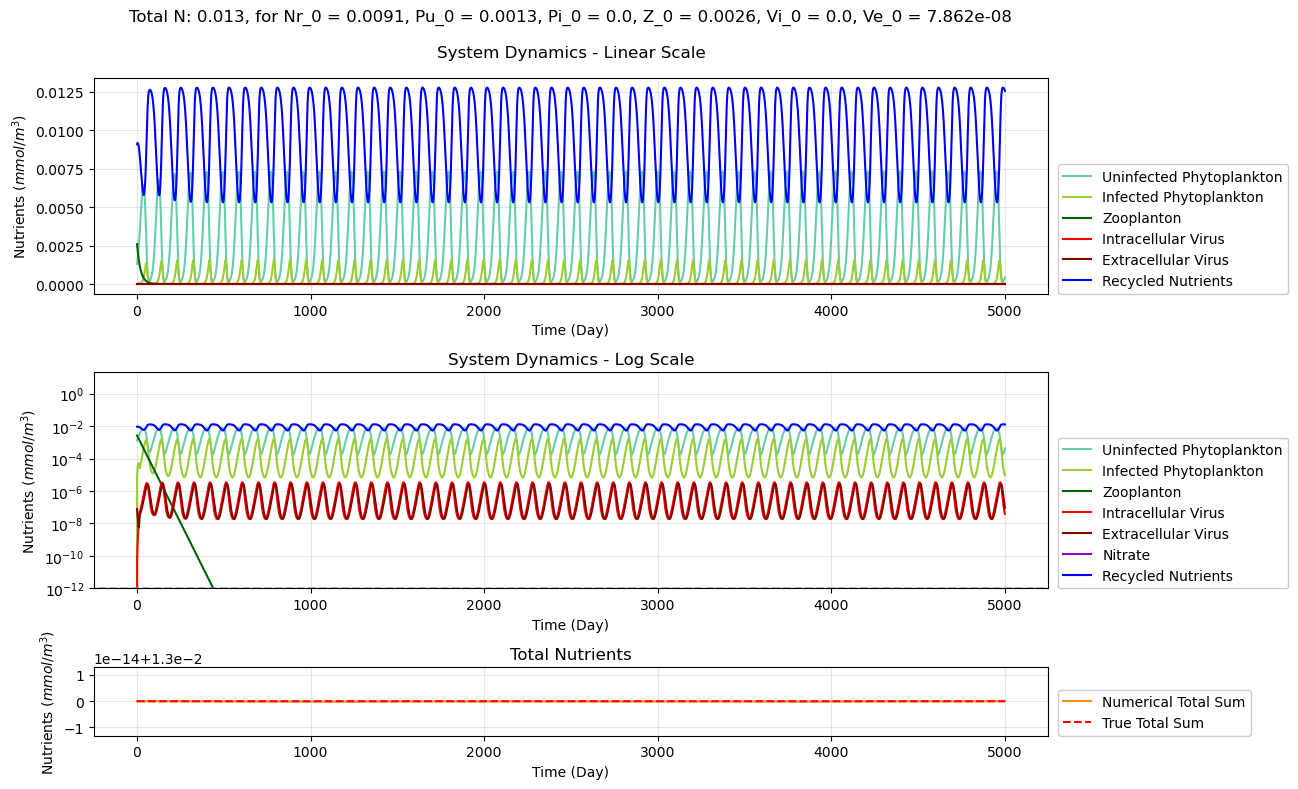

In [40]:
#Other Printing Scheme

%matplotlib inline

N_n = sol.y[0]
N_r = sol.y[1] 
P_U = sol.y[2] #Susceptible Hosts
P_I = sol.y[3] #Infected Hosts
Z   = sol.y[4] #Zooplankton
V_I = sol.y[5] #Internal viruses from host nucleotide recycling 
                #and de novo nucleotide synthesis
V_E = sol.y[6] #Free (extracellular) viruses 

fig = plt.figure(figsize = (13, 8))
ax = fig.subplot_mosaic("""A;A;B;B;C""")

###
ax["A"].plot(sol.t, P_U, color="mediumaquamarine", label='Uninfected Phytoplankton')
ax["A"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["A"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["A"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
ax["A"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
# ax["A"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
ax["A"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["A"].set_title('System Dynamics - Linear Scale')

title = (f'Total N: {Nt_0 :.8}, '
         f'for Nr_0 = {Nr_0:.4}, '
         f'Pu_0 = {Pu_0:.4}, '
         f'Pi_0 = {Pi_0:.4}, '
         f'Z_0 = {Z_0}, '
         f'Vi_0 = {Vi_0:.4}, '
         f'Ve_0 = {Ve_0:.4}\n\n'
         'System Dynamics - Linear Scale')

ax["A"].set_title(title, pad=15)

###
ax["B"].plot(sol.t, P_U, color="mediumaquamarine", label='Uninfected Phytoplankton')
ax["B"].plot(sol.t, P_I, color="yellowgreen"     , label='Infected Phytoplankton')
ax["B"].plot(sol.t, Z,   color="darkgreen"       , label='Zooplanton')
ax["B"].plot(sol.t, V_I, color="red"             , label='Intracellular Virus')
ax["B"].plot(sol.t, V_E, color="darkred"         , label='Extracellular Virus')
ax["B"].plot(sol.t, N_n, color="darkviolet"      , label='Nitrate')
ax["B"].plot(sol.t, N_r, color="blue"            , label='Recycled Nutrients')

ax["B"].axhline(y=1e-12, xmin=-20, xmax=600, c='grey', linestyle='--', alpha=.5)
# ax["B"].axhline(y=6e-19, xmin=-20, xmax=600, c='grey', linestyle='--', alpha=.5)
ax["B"].set_title('System Dynamics - Log Scale')
ax["B"].set_yscale('log')
ax["B"].set_ylim(1e-12, 20)

###
ax["C"].plot(sol.t, N_n + N_r + P_U + P_I + Z + V_I + V_E, color ='darkorange', label='Numerical Total Sum')
ax["C"].plot(sol.t, np.full(len(sol.t), sum(z0)), '--', color = 'red', label='True Total Sum')

ax["C"].set_title('Total Nutrients')

for plot in ax:
    ax[plot].set_xlabel('Time (Day)')
    ax[plot].set_ylabel(r'Nutrients ($mmol/m^3$)')
    # ax[plot].set_xlim(-2.5, 1000)
    
    ax[plot].grid(alpha=.3)
    ax[plot].legend(loc=(1.01, 0), framealpha=1)


plt.tight_layout()
plt.show()

In [6]:
print(f"Nn value at end time: {sol.y[0][-1]}")
print(f"Nr value at end time: {sol.y[1][-1]}")
print(f"Pu value at end time: {sol.y[2][-1]}")
print(f"Pi value at end time: {sol.y[3][-1]}")
print(f"Z  value at end time: {sol.y[4][-1]}")
print(f"Vi value at end time: {sol.y[5][-1]}")
print(f"Ve value at end time: {sol.y[6][-1]}")

Nn value at end time: 0.0
Nr value at end time: 0.005742210208708475
Pu value at end time: 0.00213810958705711
Pi value at end time: 0.00011916740190694692
Z  value at end time: 4.999401829291663e-25
Vi value at end time: 2.760296292070687e-07
Ve value at end time: 2.3677269828633887e-07


## Checking Steady States 

In [41]:
print(f"Ratio of host:virus concentration ratio about {sol.y[3][-1] / sol.y[5][-1]}.")
print(f"Burst size about{1 / est_viral_ratio(sol.y[5][-1], sol.y[3][-1], alpha, beta, S_ind, V_ind): .4} viruses per host.")

Ratio of host:virus concentration ratio about 98.01056205294066.
Burst size about 1.687e+03 viruses per host.


The functional form of $V_I$ in the $N_r-P_I-V_I-V_E$ or $N_r-P_I-Z-V_I-V_E$ regime is, 

$$V_I = \left(\frac{\beta}{\alpha} \frac{(\mu_V + N_{lim}  \mu'_V - \frac{g Z}{K_P} - \lambda_P)}{(\delta + \frac{g Z}{K_P}+ \lambda_P)} \right) P_I.$$

In [42]:
# Double check numerics match analytics
nutrient_lim = sol.y[1][-1] / (K_N + sol.y[1][-1])
grazing = g * sol.y[4][-1] / K_P

coeff = (beta * (μ_V + (nutrient_lim * μ_V_prime) - grazing - λ_P)) / (alpha * (δ + grazing + λ_P))
print(f"Analytical Host:Virus concentration ratio = {1 / coeff}")
print()

print(f"Numerical  Vi = {sol.y[5][-1]}")
print(f"Analytical Vi = {coeff * sol.y[3][-1]}")
print(f"Difference: {sol.y[5][-1] - coeff * sol.y[3][-1]}")

Analytical Host:Virus concentration ratio = 98.01055468229526

Numerical  Vi = 0.001986967762864975
Analytical Vi = 0.0019869679122900526
Difference: -1.4942507777990222e-10


The functional form for $V_E$ in these regimes is, 

$$V_E = \frac{V_I}{\lambda_E} (\nu_i \delta + \mu_r \lambda_P).$$

In [43]:
# Double check numerics match analytics
nu_i = sol.y[5][-1] / ((beta * sol.y[3][-1] / alpha) + sol.y[5][-1])

coeff = (nu_i * δ + μ_r * λ_P) / λ_E

print(f"Numerical  Ve = {sol.y[6][-1]}")
print(f"Analytical Ve = {coeff * sol.y[5][-1]}")
print(f"Difference: {sol.y[6][-1] - coeff * sol.y[5][-1]}")

Numerical  Ve = 0.00262791018317955
Analytical Ve = 0.0026279104692431706
Difference: -2.860636207080436e-10


In [68]:
#hhhhhheeeeeellll ya

**Change in model shape for different parameter and state initial values**

In [ ]:
def structure(t_max):
    'Computes the difference (days) between each consecutive infected pyhtoplankton peak'
    
    l = len(t_max)
    periods = []
    
    if l > 1:
        for i in range(l - 1):
            periods.append(t_max[i + 1] - t_max[i])
    else:
        periods = ["NA"]
    
    return periods

In [ ]:
#Integrate for each value of specified NON-STATE variable
varied_var = 'μ_V' 
num = 5
t = 500
#varied_values = np.linspace(0, 1, num)
varied_values = [1, 1.1, 1.11, 1.15, 1.25]
#varied_values = [1.4, 1.45, 1.47, 1.476, 1.65]


sols = []

for i, val in enumerate(varied_values):
    ind = param_labels.index(varied_var)
    param[ind] = val #redefines specified value in the initial conditions
    
    # Using brute force 
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-5, max_step = .1, method = 'LSODA')   
    
#     if solution.status == -1:
#         solution = solve_ivp(model, [0, t], z0, args=param, max_step = .1, method = "DOP853") 
        
    sols.append(solution)

In [ ]:
#Integrate for each value of specified STATE variable

varied_var = 'N_r' 
num = 400
t = 200

#varied_values = np.linspace(0, 2, num) #Start at > 0 if running perturbations
varied_values = np.logspace(-2, 3, num) * 2e-3

sols = []

for i, val in enumerate(varied_values):
    #Redifines initial state conditions
    #SET STATE VAR INDEX
    z0[1] = val
    
    solution = solve_ivp(model, [0, t], z0, args=param, min_step = 1e-8, max_step = .1, method = 'LSODA')       
    sols.append(solution)

**Testing Robusticity**

In [ ]:
#Not for large solution sets

pls_print = True
robust = {}
perturbed_sols = [[] for k in range(len(sols))]

for i, solution in enumerate(sols):
    
    z0[1] = varied_values[i] #making sure to vary total nooch levels
    
    if pls_print:
        plt.figure(figsize = (15, 2))
        plt.title(f'P_I solution for total N = {round(sum(z0), 5)}')
        plt.xlabel("Days")
        plt.ylabel("mmol N / m^3")
    
        sub = int(len(solution.t) * .95)
        plt.plot(solution.t[sub: ], solution.y[3][sub: ], label="Unperturbed")

    robust[i] = [] #Keys represent particular solution

    #Calculate new solution with perturbed intitial conditions
    print(f'Comparing perturbations of soluiton {i}...')
    
    for j in range(2): #number of randomly perturbed runs
        
        #generating appropriately sized perturbations based on initial condition levels
        perturb = np.array([0, 0, ])
        
        #disregarding N_n and N_r for now; use these quantities to balance mass later
        for k, val in enumerate(z0[2: ]): 
            
            #for some val = aeb, want 1e(b-1) <= pert <= 1eb
            b = int(math.log10(val)) #extract order of val
            
            sign = 1 if random.random() < .5 else -1  #generate random sign
            p = sign * random.uniform(10 ** (b-1), 10 ** b)  #generate random pert in desired range
            
            perturb = np.append(perturb, p)
            
        perturb[1] = -sum(perturb)  #mass balance by subtracting from N_r
        init = np.array(z0) + perturb  #redefine initital conditions with perturbations
        
        #Check for negative initial values
        if any(n < 0 for n in init): 
            print("Negative initial values; Beware!") 
            print(f"z0 = {init}")
            print()
            
#         if sum(perturb) != 0:
#             print("Perturbations do not add to zero.")
#             print(f"Sum of perturbations: {sum(perturb)}")
#             print()
        
        compare = solve_ivp(model, [0, t], init, args=param, min_step=1e-8, max_step = .1, method = 'LSODA')
        perturbed_sols[i].append(compare) #saving perturbed solutions for later
        
        if pls_print:
            sub = int(len(solution.t) * .95)
            plt.plot(compare.t[sub: ], compare.y[3][sub: ], label="Perturbed")
            plt.legend(loc=(1.02, .1))
            plt.grid(True, which="both")

        #Comparing distance of solutions 
        begin_ind = int(len(solution.t) * .9) #Finding index which partitions last 10% of data
        
        dist = []
        for point in compare.y[3][begin_ind: ]:
            d = abs(solution.y[3][-1] - point) #compare end of purturbed solution to initital solution
            dist.append(d)
        
        if len(dist) == 0:
            print("Integration Failed :(")
            print()
            continue
            
        robust[i].append(min(dist))
        
    print('Done!')

plt.show()

# Steady State Solution Behavior

In [ ]:
#Import Steady state levels

%store -r ss_sols

In [ ]:
ss_sols[1] #z0, solve_ivp solution, steady state, convergence time

In [ ]:
#Brute Force tech for vars - avg long t-span, over cohesive time chunk wrt P_I

#Define dictionary to hold steady state values at different varied_var
keys = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E", "N_T"

brute_force = {"N_n": np.array([]), "N_r": np.array([]), 
               "P_U": np.array([]), "P_I": np.array([]), 
               "Z": np.array([]), "V_I": np.array([]), 
               "V_E": np.array([]), "N_T": np.array([])}

for i, solution in enumerate(sols):
    
    total = 0
    index = int(len(solution.t) * .9) #Take last 10% of solution
    
    for k, key in enumerate(keys[:-1]):

        y_end = solution.y[k][index: ] #look at tail end of specific state
    
        l_min = argrelmin(y_end)[0]  #Extracting local minimum and maximum
        l_max = argrelmax(y_end)[0]
    
        if (len(l_min) == 0) or (len(l_max) == 0):
            avg = solution.y[k][-1]
        
        else:
            y_min = y_end[l_min]
            y_max = y_end[l_max]
            
            min_n_max = np.concatenate((y_min, y_max))
            avg = np.mean(min_n_max)
        
        brute_force[key] = np.append(brute_force[key], avg)
        total += avg
    
    
    brute_force["N_T"] = np.append(brute_force["N_T"], total)

N_T = brute_force['N_T']
N_n = brute_force['N_n']
N_r = brute_force['N_r']
P_U = brute_force['P_U']
P_I = brute_force['P_I']
Z_  = brute_force['Z']
V_I = brute_force['V_I']
V_E = brute_force['V_E']

In [ ]:
#Cummulative plot
%matplotlib inline 
fig, axs = plt.subplots(1, 2, figsize=(15, 5), width_ratios=(1, 1.5))

for ax in axs:
    ax.plot(N_T, N_T, color="blue", label='Total N')
    ax.fill_between(N_T, N_T, P_U + V_I + V_E + P_I + Z_, color='lightblue', alpha=.2)

    ax.plot(N_T, P_U, color="lightgreen", label='P_U')

    ax.plot(N_T, P_U + V_I, color="red", label='V_I')
    ax.fill_between(N_T, P_U + V_I, 0, color='red', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E, color="darkred", label='V_E')
    ax.fill_between(N_T, P_U + V_I + V_E, P_U + V_I, color='darkred', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E + P_I, color="limegreen", label='P_I')
    ax.fill_between(N_T, P_U + V_I + V_E + P_I, P_U + V_I + V_E, color='yellowgreen', alpha=.2)

    ax.plot(N_T, P_U + V_I + V_E + P_I + Z_, color="darkgreen", label='Z_')
    ax.fill_between(N_T, P_U + V_I + V_E + P_I + Z_, P_U + V_I + V_E + P_I,color='darkgreen', alpha=.2)

    ax.set_title("Cummulative Steady Sate Levels for Varying Total N")
    ax.set_xlabel(r"Total System N (mmol N / $m^3$)")
    ax.set_ylabel(r"N_T (mmol N / $m^3$)")


#Small scale regimes
axs[0].set_xlim(-.01, .2)
axs[0].set_yscale('log')
axs[0].set_ylim(6e-12, 5e1)
axs[0].grid()

#Larger scale regimes
axs[1].set_yscale('log')
axs[1].set_ylim(6e-5, 1e2)
axs[1].grid(), axs[1].legend(loc=(1.05, 0))

In [ ]:
#Non-cummulative plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

for ax in axs:

    ax.plot(N_T, P_U, color="lightgreen", label='P_U')
    ax.plot(N_T, P_I, color="limegreen", label='P_I')
    ax.plot(N_T, Z, color="darkgreen", label='Z')
    ax.plot(N_T, V_I, color="red", label='V_I')
    ax.plot(N_T, V_E, color="darkred", label='V_E')
    
    ax.set_title("Steady Sate Levels for Varying Total N")
    ax.set_xlabel(r"Total System N (mmol N / $m^3$)")
    ax.set_ylabel(r"N_T (mmol N / $m^3$)")


#Small scale regimes
axs[0].set_xlim(0, 1)
axs[0].set_yscale('log')
axs[0].set_ylim(4e-5, 2)
axs[0].grid()

#Larger scale regimes
axs[1].set_xlim(0, 20)
axs[1].set_yscale('log')
axs[1].set_ylim(4e-5, 5e1)
axs[1].grid(), axs[1].legend(loc=(1.05, 0))

In [ ]:
#Brute Force tech for duel variability - avg long t-span, over cohesive time chunk wrt P_I

#Define dictionary to hold steady state values at different varied_var
keys = "N_n", "N_r", "P_U", "P_I", "Z", "V_I", "V_E", "N_T"

brute_force = {"N_n": [[] for listt in range(len(varied_values))], "N_r": [[] for listt in range(len(varied_values))], 
               "P_U": [[] for listt in range(len(varied_values))], "P_I": [[] for listt in range(len(varied_values))], 
               "Z":   [[] for listt in range(len(varied_values))], "V_I": [[] for listt in range(len(varied_values))], 
               "V_E": [[] for listt in range(len(varied_values))], "N_T": [[] for listt in range(len(varied_values))]}


for i, row in enumerate(sols):
    
    for solution in row:
        
        total = 0
        index = int(len(solution.t) * .9) #Take last 10% of solution

        for k, key in enumerate(keys[:-1]):

            y_end = solution.y[k][index: ] #look at tail end of specific state

            l_min = argrelmin(y_end)[0]  #Extracting local minimum and maximum
            l_max = argrelmax(y_end)[0]

            if (len(l_min) == 0) or (len(l_max) == 0):
                avg = solution.y[k][-1]

            else:
                y_min = y_end[l_min]
                y_max = y_end[l_max]

                min_n_max = np.concatenate((y_min, y_max))
                avg = np.mean(min_n_max)

            brute_force[key][i] = np.append(brute_force[key][i], avg)
            total += avg

        brute_force["N_T"][i] = np.append(brute_force["N_T"][i], total)

        
N_T = brute_force['N_T']
N_n = brute_force['N_n']
N_r = brute_force['N_r']
P_U = brute_force['P_U']
P_I = brute_force['P_I']
Z_  = brute_force['Z']
V_I = brute_force['V_I']
V_E = brute_force['V_E']

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 9))

markers = 'o', '*', 'x', 'D', 's'
colors = 'darkslategrey', 'teal', 'aquamarine', 'gold', 'darkgoldenrod'

for i in range(len(varied_values)):
    
    axs[0][0].scatter(N_T[i], P_I[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[0][1].scatter(N_T[i], Z_[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[1][0].scatter(N_T[i], V_I[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    axs[1][1].scatter(N_T[i], V_E[i], marker=markers[i], color=colors[i], label=f'{varied_var} = {varied_values[i]}', s=10)
    
    
axs[0][0].set_ylabel(r'P_I (mmol N / $m^3$)')    
axs[0][1].set_ylabel(r'Z (mmol N / $m^3$)')    
axs[1][0].set_ylabel(r'V_I (mmol N / $m^3$)')    
axs[1][1].set_ylabel(r'V_E (mmol N / $m^3$)')    

for ax in axs:
    ax[0].set_xlabel(r'Total Nutrients (mmol N / $m^3$)')    
    ax[0].set_xlim(0, 21)
    ax[0].grid(alpha=.3)
    ax[0].legend()

    ax[1].set_xlabel(r'Total Nutrients (mmol N / $m^3$)')
    ax[1].set_xlim(0, 20)
    ax[1].grid(alpha=.3)
    ax[1].legend()
    
plt.suptitle(f'Steady State Responce to Variability in Sink Parameter {varied_var}', fontsize=14)
plt.tight_layout()

In [ ]:
#Imported steady state levels from NPZ 

%store -r N
%store -r P
%store -r Z

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(17, 4))
fig.suptitle("Comparison of Steady State Solutions from NPZ & NPZV")

ax[0].scatter(N_T, N, s=3, color= "darkgoldenrod", label='N - NPZ')
ax[0].scatter(N_T, N_r, s=3, color= "darkslategrey" , label='N_r - NPZV')

ax[1].scatter(N_T, P, s=3, color= "darkgoldenrod", label='P - NPZ')
ax[1].scatter(N_T, P_I, s=3, color= "darkslategrey" , label='P_I - NPZV')

ax[2].scatter(N_T, Z, s=3, color= "darkgoldenrod" , label='Z - NPZ')
ax[2].scatter(N_T, Z_, s=3, color= "darkslategrey" , label='Z - NPZV')

for a in ax:
    a.set_xlabel(r"Total Nutrients (mmol N / $m^3$)")
    a.set_ylabel(r"mmol N / $m^3$")
    a.legend()
    a.grid(alpha=.3)

In [ ]:
#Steady state function for optimization technique
def steady_state(X, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_V, μ_V_prime, 
          μ_u, μ_r, μ_s, μ_P, μ_delta, μ_g, μ_Z, K_N, K_I, K_h, K_P, I_0, ω):
    
    N_n = X[0]
    N_r = X[1]
    P_U = X[2] #Susceptible Hosts
    P_I = X[3] #Infected Hosts
    Z   = X[4] #Zooplankton
    V_I = X[5] #Internal viruses from host nucleotide recycling 
               #and de novo nucleotide synthesis
    V_E = X[6] #Free (extracellular) viruses 
    
    alpha = (1 / 1.42e8) * 2.1e-10 * 1e6 # host conversion, mmol ml / NT m^3
    beta  = (1 / 4e5) * 1.27e-15 * 1e6   # viral conversion, mmol ml / NT m^3
    
    if P_I == 0 or V_I == 0:  ν_i = 1
        
    else:
        ν_i = (V_I / beta) / ((P_I / alpha) + (V_I / beta)) 
                                     #mimics delay in internal viral production 
                                     #and host lysis, due to internal assymbly 
                                     #of viral progeny 
    P = P_U + P_I
    
    N = N_n + N_r
    
    nutr_lim = N / (K_N + N)

    light_lim = np.log((K_I + I_0 / K_I)) / K_h  #light limitation term
    
    #Phytoplankton uninfected
    P_U_growth    = (P_U + μ_u * P_I) * V_max * nutr_lim * light_lim
    P_U_grazing   = P_U * g * Z / K_P
    P_U_mortality = P_U * λ_P
    P_U_adsorp    = P_U * (1 - ν_x) * φ * μ_s * V_E
    P_U_entrain   = P_U * ω
    
    P_U_dt = P_U_growth - P_U_grazing - P_U_mortality - P_U_adsorp - P_U_entrain
    
    
    #Phytoplankton infected
    P_I_adsorp       = (1 - ν_x) * φ * μ_s * P_U * V_E
    P_I_growth       = (1 - μ_u) * P_I * V_max * nutr_lim * light_lim
    P_I_grazing      = P_I * g * Z / K_P
    P_I_mortality    = P_I * λ_P
    P_I_nt_recycling = P_I * ν_i * μ_V
    P_I_lysis        = P_I * ν_i * δ
    P_I_entrain      = P_I * ω
    
    P_I_dt = P_I_adsorp + P_I_growth - P_I_grazing - P_I_mortality \
             - P_I_nt_recycling - P_I_lysis - P_I_entrain
    
    
    #Zooplankton
    Z_assimilation = Z * γ_Z * g * (P + V_I) / K_P
    Z_mortality    = Z * (λ_Z + λ_Z_hat * Z)
    Z_entrain      = Z * ω
    
    Z_dt = Z_assimilation - Z_mortality - Z_entrain
    
    
    #Intracellular viruses
    V_I_growth  = ν_i * (beta / alpha) * (μ_V + (nutr_lim * μ_V_prime)) * P_I
    V_I_adsorp  = ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_I_lysis   = V_I * ν_i * δ
    V_I_grazing = V_I * g * Z / K_P
    V_I_h_mort  = V_I * λ_P
    V_I_entrain = V_I * ω
    
    V_I_dt = V_I_growth + V_I_adsorp - V_I_lysis - V_I_grazing - V_I_h_mort - V_I_entrain
    
    
    #Extracellular
    V_E_adsorp    = ν_x * (beta / alpha) * φ * μ_s * P_U * V_E
    V_E_h_mort    = V_I * μ_r * λ_P
    V_E_mortality = λ_E * V_E
    V_E_entrain   = V_E * ω
    
    V_E_dt = - V_E_adsorp + V_I_lysis + V_E_h_mort - V_E_mortality - V_E_entrain
    
    
    #Nitrate
    if N != 0:
        N_n_accum = (N_n / N) * P * V_max * nutr_lim * light_lim
    else:
        N_n_accum = 0 
        
    N_n_intracell = (N_n / N) * ν_i * P_I * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_n_entrain   = ω * N_n 
    
    N_n_dt = - N_n_accum - N_n_intracell - N_n_entrain
            
        
    #Recycled nutrients
    if N != 0:
        N_r_accum = (N_r / N) * P * V_max * nutr_lim * light_lim
    else:
        N_r_accum = 0 
    
    nt_recycling     = ν_i * P_I * (1 - (beta / alpha)) * μ_V
    denovo_syn       = (N_r / N) * (beta / alpha) * (nutr_lim * μ_V_prime)
    N_r_intracell    = nt_recycling - denovo_syn
    
    N_r_mortality    = λ_P * (P + (1 - μ_r) * V_I)
    N_r_Ve_mort      = λ_E * V_E
    N_r_lysis        = ν_i * δ * P_I
    N_r_sloppy_munch = (1 - γ_Z) * g * Z * (P + V_I) / K_P
    N_r_entrain      = N_r * ω
    
    N_r_remin  = (μ_P * N_r_mortality) + N_r_Ve_mort + (μ_delta * N_r_lysis) \
             + (μ_g * N_r_sloppy_munch) + (μ_Z * Z_mortality) - N_r_entrain

    N_r_export = (1 - μ_P) * N_r_mortality + (1 - μ_delta) * N_r_lysis \
             + (1 - μ_g) * N_r_sloppy_munch + (1 - μ_Z) * Z_mortality
    
    N_r_dt = - N_r_accum - N_r_intracell + N_r_remin + N_r_export

    
    return norm([N_n_dt, N_r_dt, P_U_dt, P_I_dt, Z_dt, V_I_dt, V_E_dt]) ** 2

In [ ]:
#Optimization technique

#pulling initial values from one long time span run
# ind = param_labels.index(varied_var)
# param[ind] = varied_values[0]
# solution = solve_ivp(model, [0, 5000], z0, args=param, max_step=.1, method='LSODA')

# N_n = solution.y[0]
# N_r = solution.y[1] 
# P_U = solution.y[2] #Susceptible Hosts
# P_I = solution.y[3] #Infected Hosts
# Z   = solution.y[4] #Zooplankton
# V_I = solution.y[5] #Internal viruses from host nucleotide recycling 
#                 #and de novo nucleotide synthesis
# V_E = solution.y[6] #Free (extracellular) viruses 

# index = -1
# solver = {"N_n": [N_n[index]], "N_r": [N_r[index]], "P_U": [(P_U[index])], 
#           "P_I": [P_I[index]], "Z": [Z[index]], "V_I": [V_I[index]], 
#           "V_E": [V_E[index]],"N_T": []}

# for val in varied_values:
#     ind = param_labels.index(varied_var)
#     # this line redefines the specified value in the initial conditions
#     param[ind] = val
    
#     #define initial condition parameter as previous steady-state solution
#     i_0 = [solver[k][-1] for k in keys[:-1]] 
    
#     #bounding state variables, such that SS solutions are always positive
#     bnds = [(0, None) for i in range(7)]
    
#     #Mass balance constraint - sum of the state variables must be equal 
#     #to the sum of the original steady-state solution, for which the mass the system was defined
#     initial_mass = sum([solver[k][0] for k in keys[:-1]])
#     con = {'type': 'eq', 'fun': lambda X: sum([X[i] for i in range(7)]) - initial_mass}

#     solution = minimize(steady_state, i_0, args=tuple(param), bounds = bnds, constraints = con, tol = 1e-10)
    
#     for i, k in enumerate(keys[:-1]):
#         solver[k].append(solution.x[i])
        
#     solver["N_T"].append(sum(i_0))

In [ ]:
fig, axs = plt.subplots(8, constrained_layout=True, figsize=(12, 20))
fig.suptitle(f"Steady State Response to Variability in {varied_var}")

for i, k in enumerate(keys[:-1]):
    axs[i].scatter(varied_values, brute_force[k][0], color='black')
    axs[i].plot(varied_values, brute_force[k][0], color='black', label = "Long Time Span")
    
    for j, txt in enumerate(brute_force[k][1]):
        axs[i].annotate(txt, (varied_values[j], brute_force[k][0][j]))
    
    #axs[i].scatter(varied_values, solver[k][1:], color='black')
    #axs[i].plot(varied_values, solver[k][1:], '--', color='black', label = 'Minimizer')
    
    axs[i].set_ylabel(f"{k}   (mmol/m^3)")
    axs[i].grid(alpha=.3)
    axs[i].legend()
    
axs[7].plot(varied_values, brute_force["N_T"], label = "Long Time Span")
#axs[7].plot(varied_values, solver["N_T"], label = 'Minimizer')
axs[7].set_xlabel(f'Values of {varied_var}')
axs[7].set_ylabel('Total Nutrients')
axs[7].set_title('Sum of Steady State Solutions')

axs[7].grid(alpha=.3); axs[7].legend()

**Attempt at finding limit cycles...**

In [ ]:
# def objective_function(tX0, V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_P,
#           μ_V, μ_V_prime, μ_delta, μ_m, μ_g, μ_Z, K_N, K_I, K_Z, K_P, I_0, ω):
    
#     t = tX0[0]
#     x0 = tX0[1:]
    
#     param = [V_max, γ_Z, φ, g, ν_x, λ_P, λ_Z, λ_Z_hat, λ_E, δ, μ_P,
#           μ_V, μ_V_prime, μ_delta, μ_m, μ_g, μ_Z, K_N, K_I, K_Z, K_P, I_0, ω]
    
#     solution = solve_ivp(model, [0, t], x0, args=param, max_step=.1, method = 'LSODA')
#     difference = [x0[i] - solution.y[i][-1] for i in range(len(x0))]
    
#     return norm(difference)